# Sea Ice Coordinates & Plotting Examples

This script shows how to load and plot sea ice concentration from sea ice models (CICE5, and SIS2) output, while also indicating how to get around some of the pitfalls and foibles in CICE temporal and spatial gridding.

Requirements: The `conda/analysis3` module from `/g/data/xp65/public/modules`. 



In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46311,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39087,Total threads: 1
Dashboard: /proxy/42941/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:44185,


In [1]:
from esmvalcore.dataset import Dataset

model = Dataset(
    short_name='siconc', mip='SImon', project='CMIP6', activity='CMIP',
    dataset='ACCESS-ESM1-5', ensemble='r1i1p1f1', grid='gn', exp='historical',
    timerange='1981/1991', institute = '*',
)

om_facets={'dataset' :'ACCESS-OM2', 'exp':'omip2', 'activity':'OMIP', 'timerange':'0306/0366' }

model.add_supplementary(short_name='areacello', mip='Ofx')

model_om = model.copy(**om_facets)

# Sea Ice Area

Let's look at a timeseries of SH sea ice area. Area is defined (per convention) as the sum of sea ice concentration multiply by the area of each grid cell (and masked for sea ice concentration above 15%)

By convention, sea-ice area for a region or basin is the sum of the area's where concentration is greater than 15%. 
We also need to drop geolon and geolat so we have unique longitude and latitude to reference

In [2]:
from esmvalcore.preprocessor import (
            mask_outside_range,
            extract_region,
            area_statistics,
)

nh_sh_lat = {'NH':(45,90),'SH':(-90,-45)}

def sea_ice_area(cube, hemisphere):
    cube = mask_outside_range(cube, 15, 100)  #above 15%
    cube = extract_region(cube,0,360,*hemisphere) #SH #NH 45, 90
    cube = area_statistics(cube, 'sum')  #units become '0.01 m2'
    cube.convert_units('m2')
    return cube


Text(0, 0.5, 'Sea Ice Area (m$^{2}$)')

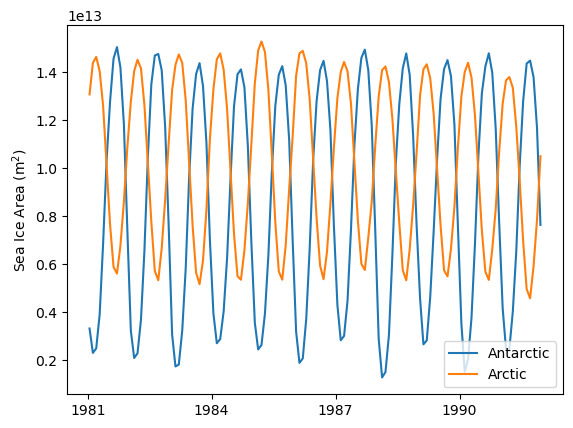

In [3]:
import iris.plot as iplt
import matplotlib.pyplot as plt

cube = model.load()
cube_sh = sea_ice_area(cube, nh_sh_lat['SH'])
cube_nh = sea_ice_area(cube, nh_sh_lat['NH'])

iplt.plot(cube_sh, label = 'Antarctic')
iplt.plot(cube_nh, label = 'Arctic')
plt.legend(loc='lower right')
plt.ylabel('Sea Ice Area (m$^{2}$)')

As we are using a repeat year forcing experiemnt, the sea ice cycle is very regular:

And the seasonal cycle of sea-ice area:

Text(0, 0.5, 'Sea Ice Area (m$^{2}$)')

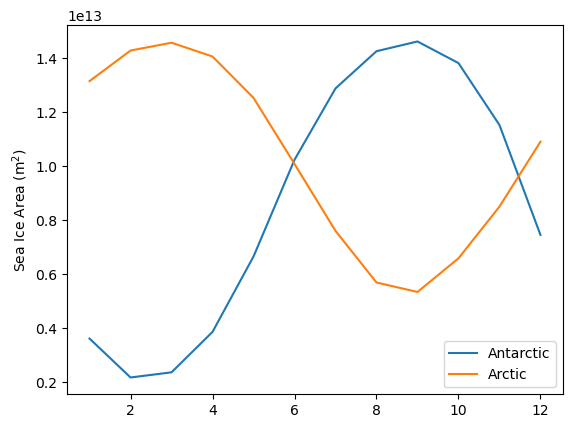

In [4]:
from esmvalcore.preprocessor import climate_statistics

seas_cycle = climate_statistics(cube_sh, period='monthly', operator='mean')

iplt.plot(seas_cycle, label = 'Antarctic')
iplt.plot(climate_statistics(cube_nh, period='monthly', operator='mean'), label = 'Arctic')
plt.legend()
plt.ylabel('Sea Ice Area (m$^{2}$)')

# Making Maps

If we just plot a selected month now, you see that everything North of 65N is skewed. 

In [5]:
cube.summary(shorten=True)

'sea_ice_area_fraction / (%)         (time: 132; cell index along second dimension: 300; cell index along first dimension: 360)'

[cftime.DatetimeProlepticGregorian(1981, 9, 16, 0, 0, 0, 0, has_year_zero=True)]


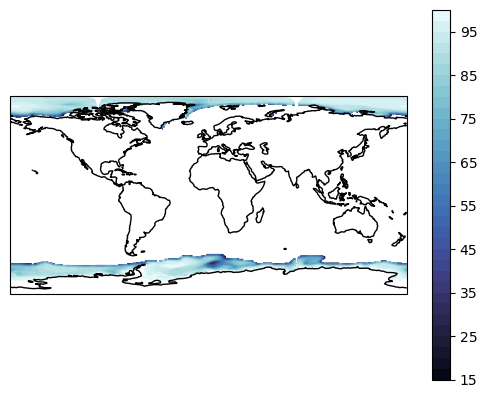

In [13]:
import cartopy.crs as ccrs
import cmocean.cm as cmo
from esmvalcore.preprocessor import regrid

ax = plt.subplot(projection = ccrs.PlateCarree())

# sic.sel(time='1985-08').plot(cmap = cmo.ice)
# iplt.pcolormesh(cube[0], cmap = cmo.ice)
# climate_statistics(cube, period='monthly', operator='mean') #select month

# regrid and plot contourf
cube_regrid = regrid(cube[8], target_grid='0.5x0.5', scheme='linear')
iplt.contourf(cube_regrid, levels = 33, cmap = cmo.ice)
ax.coastlines()
plt.colorbar() #sea ice concentration percent
print(cube_regrid.coord('time').units.num2date(cube_regrid.coord('time').points))

Most of our work is in the Southern Ocean, so maybe we don't care. But if you are interested in the Arctic, then we need to account for the tri-polar ocean grid that out models use. The easiest way out of that is using contourf, and the passing the x and y coordinates.

See [Making Maps with Cartopy](https://cosima-recipes.readthedocs.io/en/latest/Tutorials/Making_Maps_with_Cartopy.html) tutorial for more help with plotting!

We need the geolon and geolat fields from the model for the actual (two-pole) coordinates, instead of the model (three-pole) coordinates.

Using cartopy, we can make Polar Stereographic plots of sea ice concentration for a selected month, as follows:

In [36]:
import numpy as np
import matplotlib.path as mpath
import cartopy.feature as cfeature

def plot_si_conc(cube):
    """ A function for plotting tri-polar data"""
    ax = plt.gca()

    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    # Add land features and gridlines
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black',
                   facecolor = 'gainsboro'), zorder = 2)

    iplt.contourf(cube,
        # transform = ccrs.PlateCarree(),
        levels = np.arange(15, 105, 5),
        cmap = cmo.ice,
    )
    plt.colorbar(label='Sea Ice Conentration %')
    
    gl = ax.gridlines(
            draw_labels=True, linewidth=1, color='gray', alpha=0.2, linestyle='--',
            ylocs = np.arange(-80, 81, 10)
        )

    ax.coastlines()
    print(cube.coord('time').units.num2date(cube.coord('time').points)[0].strftime())

1981-08-16 12:00:00


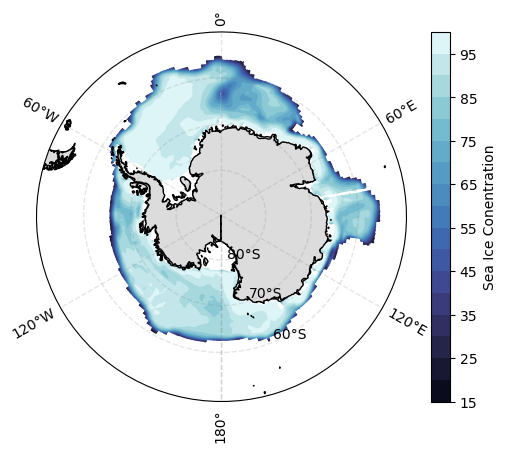

In [37]:
def plot_sh_si_conc():
    ax = plt.subplot(projection=ccrs.SouthPolarStereo())

    ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())

    plot_si_conc(
        # sic.cf.sel(time='1985-08').squeeze('time')
        regrid(cube[7], target_grid='0.25x0.25', scheme='linear')
    )

plot_sh_si_conc()

1981-02-15 00:00:00


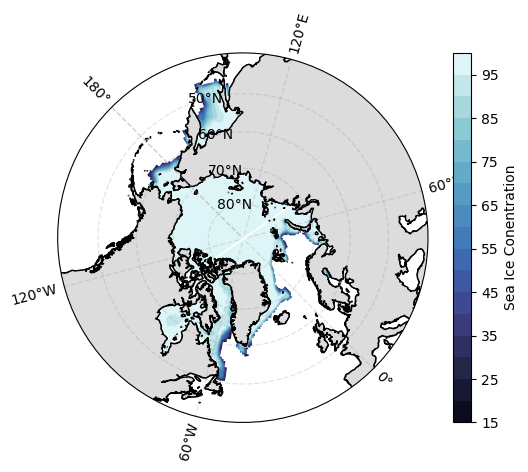

In [39]:
def plot_nh_si_conc():
    ax = plt.subplot(projection=ccrs.NorthPolarStereo(central_longitude=-45))
    
    ax.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())

    plot_si_conc(
        regrid(cube[1], target_grid='0.25x0.25', scheme='linear')
    )

plot_nh_si_conc()

Once we are happy with your plot, we can save the plot to disk using `plt.savefig('filepath/filename')` function at the end of the cell containing the plot we want to save, as shown below. Note that your filename must contain the file (e.g., pdf, jpeg, png, etc.).  
For more information on the options available to save figures refer to [Matplotlib documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html).

```python
plot_sh_si_conc()
plt.savefig('MyFirstSeaIcePlot.png', dpi = 300)
```

In [27]:
client.close()